# Decision Trees and Random Forests

Decision Trees are a non-parametric supervised learning method used for classification and regression. The goal is to create a model that predicts the value of a target variable by learning simple decision rules inferred from the data features.

Decision Trees learn from data with a set of if-then-else decision rules. The deeper the tree, the more complex the decision rules and the fitter the model.

More information in [Decision Trees](https://scikit-learn.org/stable/modules/tree.html).

In [94]:
# Import the necessary modules and libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier

import warnings
warnings.simplefilter('ignore')

%matplotlib inline
%config InlineBackend.figure_format = "retina"

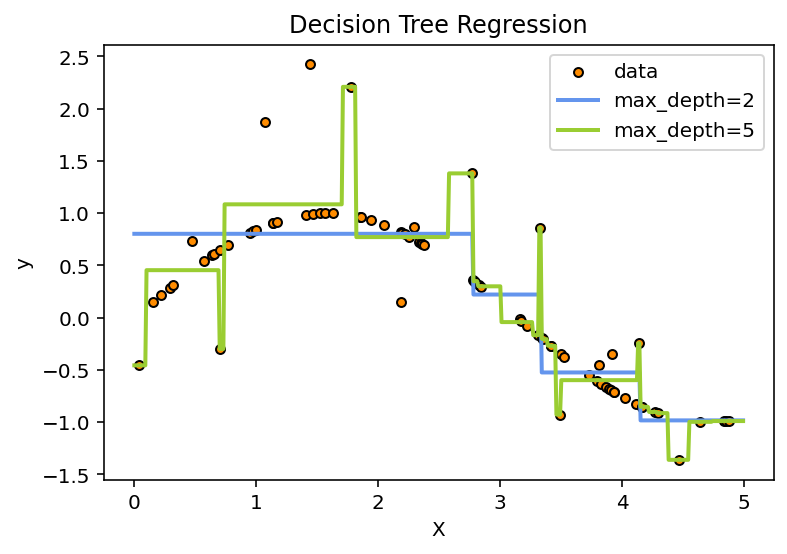

In [95]:
# Create a random dataset
rng = np.random.default_rng(42)
X = np.sort(5 * rng.random(80), axis=0).reshape(-1, 1)
X_test = np.arange(0.0, 5.0, 0.01)[:, np.newaxis]
y = np.sin(X).ravel()
y[::5] += 3 * (0.5 - rng.random(16))

# Fit and predict regression model with max_depth=2
regr_1 = DecisionTreeRegressor(max_depth=2)
regr_1.fit(X, y)
y_1 = regr_1.predict(X_test)

# Fit regression model with max_depth=5
regr_2 = DecisionTreeRegressor(max_depth=5)
regr_2.fit(X, y)
y_2 = regr_2.predict(X_test)

# Plot the results
plt.figure()
plt.scatter(X, y, s=20, edgecolor="black", c="darkorange", label="data")
plt.plot(X_test, y_1, color="cornflowerblue", label="max_depth=2", linewidth=2)
plt.plot(X_test, y_2, color="yellowgreen", label="max_depth=5", linewidth=2)
plt.xlabel("X")
plt.ylabel("y")
plt.title("Decision Tree Regression")
plt.legend()
plt.show()

## Decision Trees

This data set consists of 3 different types of irises' (Setosa, Versicolour, and Virginica) petal and sepal length, stored in a 150x4 array. The rows being the samples and the columns being: Sepal Length, Sepal Width, Petal Length and Petal Width.

In [96]:
from sklearn.datasets import load_iris
from sklearn.tree import plot_tree, export_graphviz

iris = load_iris()
X = pd.DataFrame(iris.data, columns=iris.feature_names)
y = pd.DataFrame(iris.target, columns=["species"])
clf = DecisionTreeClassifier(max_leaf_nodes=3, random_state=42)
clf.fit(X, y)

DecisionTreeClassifier(max_leaf_nodes=3, random_state=42)

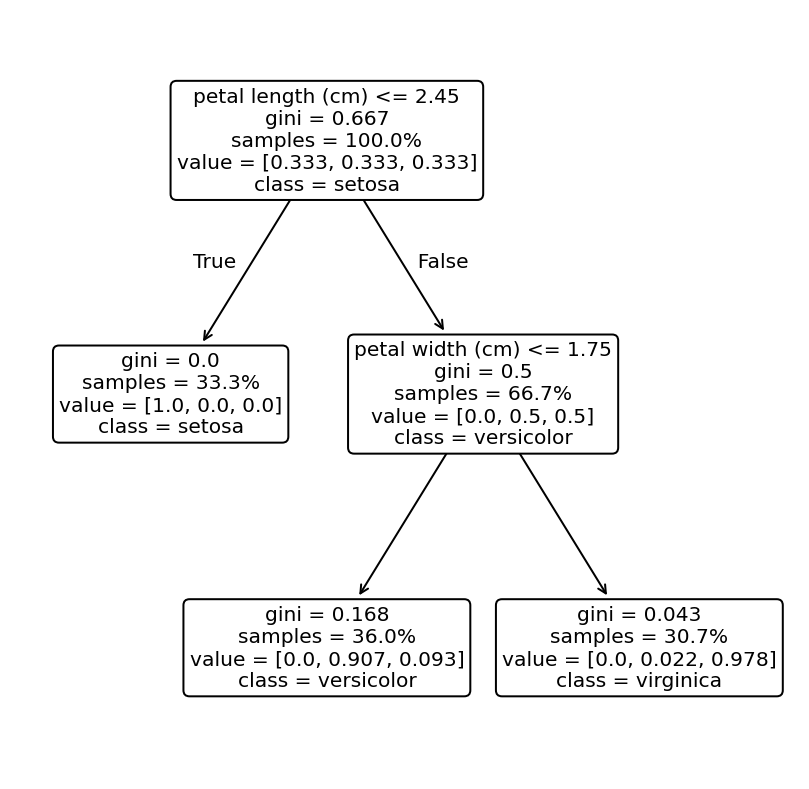

In [97]:
plt.figure(figsize=(7, 7))
plot_tree(clf, proportion=True, rounded=True,
          feature_names=iris.feature_names, class_names=iris.target_names)
plt.show()

For example, in the above tree built on the iris dataset, the root node has value = [0.33, 0.33, 0.33] indicating there are 33% of class 0 samples, 33% of class 1 samples, and 33% of class 2 samples at the root node. 

One can convert this to the absolute number of samples by multiplying by the number of samples reaching the root node, which is `clf.tree_.weighted_n_node_samples[0]`. Then the root node has value = [50, 50, 50].

Traversing the tree, the samples are split and as a result, the value array reaching each node changes. The left child of the root node has value = [1., 0, 0] because all 50 samples in the left child node are from class 0.

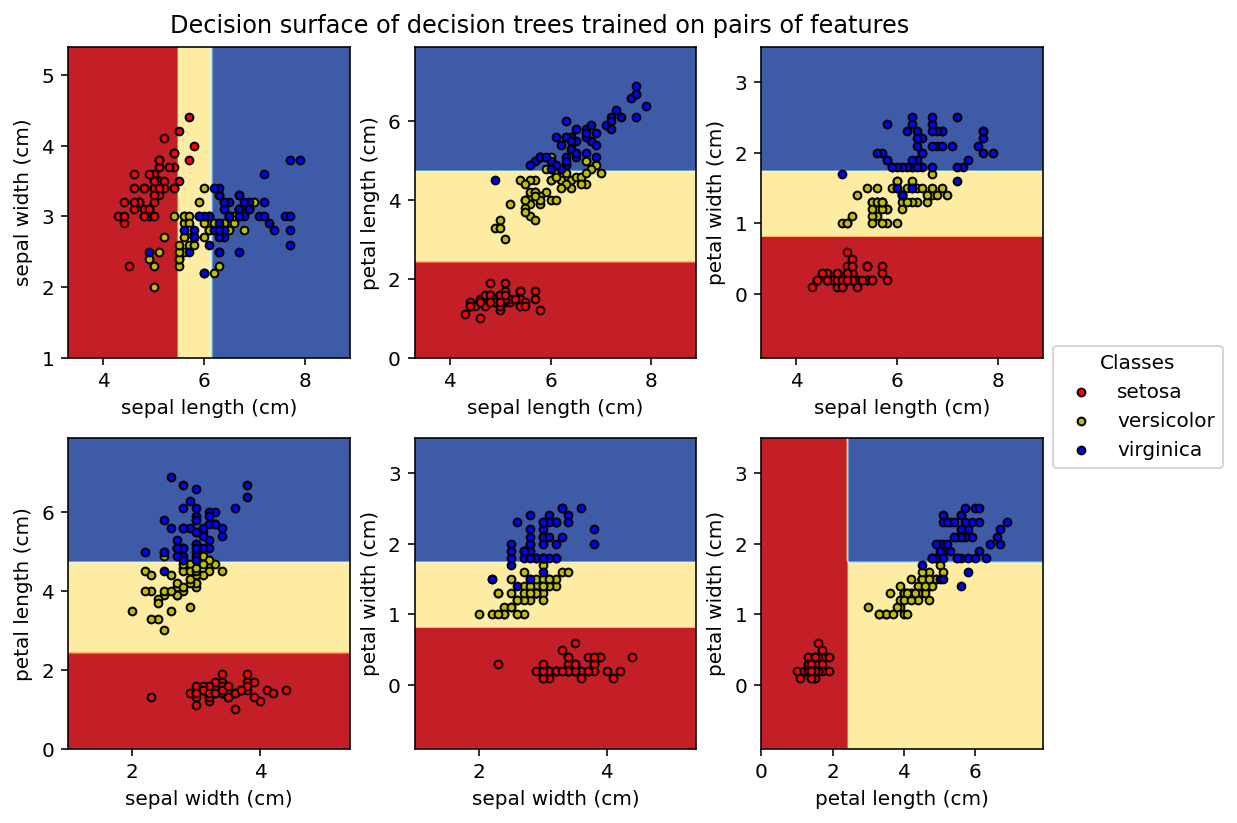

In [98]:
from sklearn.inspection import DecisionBoundaryDisplay

# Parameters
n_classes = 3
plot_colors = "ryb"
plot_step = 0.02
plt.figure(figsize=(8, 6))

for pairidx, pair in enumerate([[0, 1], [0, 2], [0, 3], [1, 2], [1, 3], [2, 3]]):
    # We only take the two corresponding features
    X = iris.data[:, pair]
    y = iris.target

    # Train
    clf = DecisionTreeClassifier(max_leaf_nodes=3, random_state=42).fit(X, y)

    # Plot the decision boundary
    ax = plt.subplot(2, 3, pairidx + 1)
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)
    DecisionBoundaryDisplay.from_estimator(
        clf,
        X,
        cmap=plt.cm.RdYlBu,
        response_method="predict",
        ax=ax,
        xlabel=iris.feature_names[pair[0]],
        ylabel=iris.feature_names[pair[1]],
    )

    # Plot the training points
    for i, color in zip(range(n_classes), plot_colors):
        idx = np.where(y == i)
        plt.scatter(
            X[idx, 0],
            X[idx, 1],
            c=color,
            label=iris.target_names[i],
            edgecolor="black",
            s=15,
        )

plt.suptitle("Decision surface of decision trees trained on pairs of features")
plt.legend(loc="center left", bbox_to_anchor=(1, 1.1), title="Classes")
_ = plt.axis("tight")

Plot of decision surface of a decision tree trained on pairs of features of the iris dataset.

For each pair of iris features, the decision tree learns decision boundaries made of combinations of simple thresholding rules inferred from the training samples.

### Using Graphviz

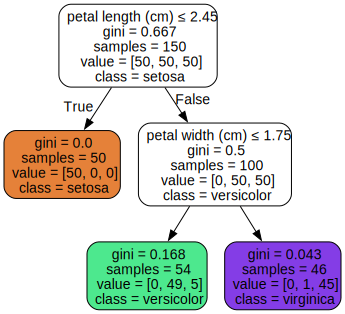

In [99]:
import graphviz

X = pd.DataFrame(iris.data, columns=iris.feature_names)
y = pd.DataFrame(iris.target, columns=["species"])
clf = DecisionTreeClassifier(max_leaf_nodes=3, random_state=42)
clf.fit(X, y)

dot_data = export_graphviz(clf, out_file=None, feature_names=iris.feature_names,
                           class_names=iris.target_names, filled=True, rounded=True,
                           special_characters=True)
graph = graphviz.Source(dot_data)
graph

### Tips on practical use:

1.	Overfitting and Dimensionality Reduction: Decision trees tend to overfit with many features. Dimensionality reduction (e.g., PCA or feature selection) can help by focusing on key discriminative features.

2.	Tree Structure and Visualization: Visualizing the tree helps understand its predictions. Start with `max_depth=3` to assess fit, then adjust accordingly.

3.	Sample Size Control: Control tree growth with max_depth, as the required samples double with each level. Use `min_samples_leaf=5` to ensure each decision is based on sufficient samples and avoid overfitting.

4.	Class Imbalance: Balance classes before training to avoid bias. Normalizing sample weights helps prevent trees from favoring dominant classes.

5.	Sparse Matrix Optimization: Use sparse matrices (e.g., csc_matrix for fitting and csr_matrix for predicting) when input data contains many zero values, as it improves training speed significantly.

## Random Forests

Ensemble methods combine the predictions of several base estimators built with a given learning algorithm in order to improve over a single estimator.

Random Forests are an ensemble learning method that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting.

In random forests, each tree in the ensemble is built from a sample drawn with replacement (i.e., a bootstrap sample) from the training set. Furthermore, when splitting each node during the construction of a tree, the best split is found through an exhaustive search of the features values of either all input features or a random subset of size `max_features`. (See the parameter tuning guidelines for more details.)

The purpose of these two sources of randomness is to decrease the variance of the forest estimator. In practice the variance reduction is often significant hence yielding an overall better model.

In [100]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

clf = DecisionTreeClassifier(max_depth=None, min_samples_split=2, random_state=42)
scores = cross_val_score(clf, X, y, cv=5)
print("Decision Tree Accuracy: %0.3f (+/- %0.3f)" % (scores.mean(), scores.std() * 2))

clf = RandomForestClassifier(n_estimators=10, max_depth=None, min_samples_split=2, random_state=42)
scores = cross_val_score(clf, X, y, cv=5)
print("Random Forest Accuracy: %0.3f (+/- %0.3f)" % (scores.mean(), scores.std() * 2))

Decision Tree Accuracy: 0.953 (+/- 0.068)
Random Forest Accuracy: 0.967 (+/- 0.042)


DecisionTree with features [0, 1] has a score of 0.927
RandomForest with 30 estimators with features [0, 1] has a score of 0.913
DecisionTree with features [0, 2] has a score of 0.993
RandomForest with 30 estimators with features [0, 2] has a score of 0.993
DecisionTree with features [2, 3] has a score of 0.993
RandomForest with 30 estimators with features [2, 3] has a score of 0.993


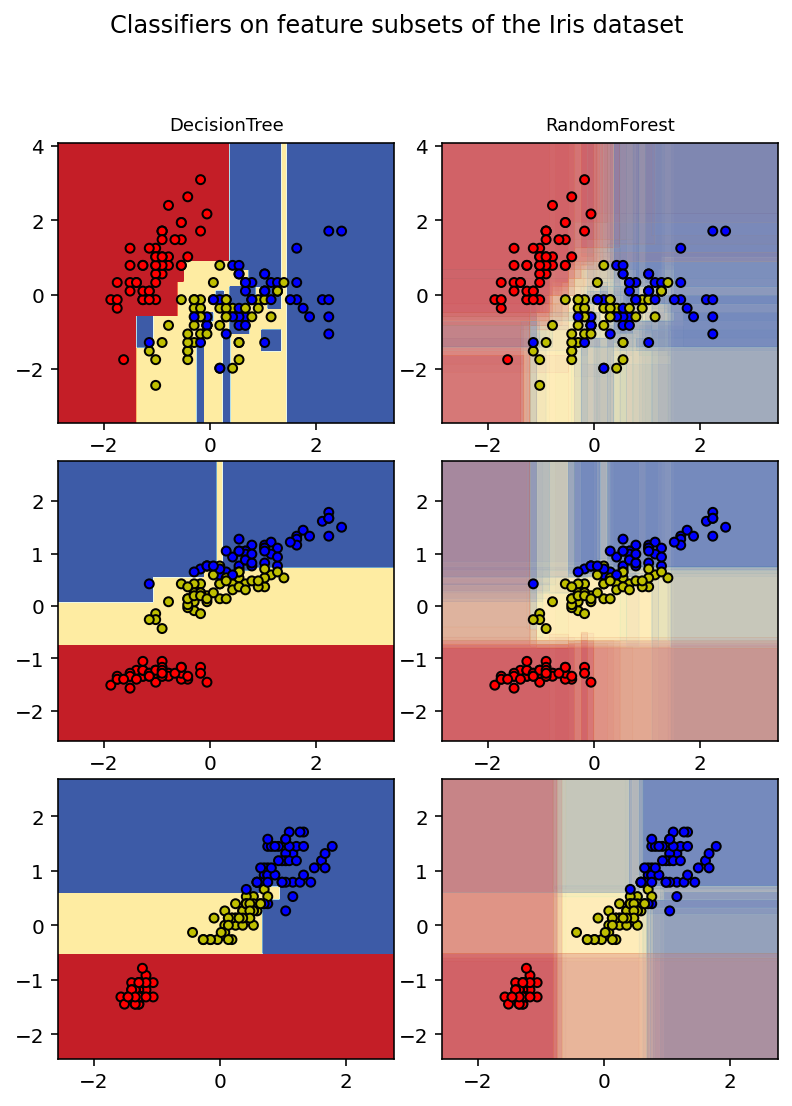

In [106]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

# Parameters
n_classes = 3
n_estimators = 30
cmap = plt.cm.RdYlBu
plot_step = 0.02  # fine step width for decision surface contours
plot_step_coarser = 0.5  # step widths for coarse classifier guesses
RANDOM_SEED = 42  # fix the seed on each iteration
plt.figure(figsize=(6, 8))

# Load data
iris = load_iris()

plot_idx = 1

models = [
    DecisionTreeClassifier(max_depth=None),
    RandomForestClassifier(n_estimators=n_estimators),
]

for pair in ([0, 1], [0, 2], [2, 3]):
    for model in models:
        # We only take the two corresponding features
        X = iris.data[:, pair]
        y = iris.target

        # Shuffle
        idx = np.arange(X.shape[0])
        np.random.seed(RANDOM_SEED)
        np.random.shuffle(idx)
        X = X[idx]
        y = y[idx]

        # Standardize
        mean = X.mean(axis=0)
        std = X.std(axis=0)
        X = (X - mean) / std

        # Train
        model.fit(X, y)

        scores = model.score(X, y)
        # Create a title for each column and the console by using str() and
        # slicing away useless parts of the string
        model_title = str(type(model)).split(".")[-1][:-2][: -len("Classifier")]

        model_details = model_title
        if hasattr(model, "estimators_"):
            model_details += " with {} estimators".format(len(model.estimators_))
        print(model_details + " with features", pair, "has a score of", round(scores, 3))

        plt.subplot(3, 2, plot_idx)
        if plot_idx <= len(models):
            # Add a title at the top of each column
            plt.title(model_title, fontsize=9)

        # Now plot the decision boundary using a fine mesh as input to a
        # filled contour plot
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        xx, yy = np.meshgrid(
            np.arange(x_min, x_max, plot_step), np.arange(y_min, y_max, plot_step)
        )

        # Plot either a single DecisionTreeClassifier or alpha blend the
        # decision surfaces of the ensemble of classifiers
        if isinstance(model, DecisionTreeClassifier):
            Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
            Z = Z.reshape(xx.shape)
            cs = plt.contourf(xx, yy, Z, cmap=cmap)
        else:
            # Choose alpha blend level with respect to the number of estimators
            # that are in use (noting that AdaBoost can use fewer estimators
            # than its maximum if it achieves a good enough fit early on)
            estimator_alpha = 1.0 / len(model.estimators_)
            for tree in model.estimators_:
                Z = tree.predict(np.c_[xx.ravel(), yy.ravel()])
                Z = Z.reshape(xx.shape)
                cs = plt.contourf(xx, yy, Z, alpha=estimator_alpha, cmap=cmap)

        # Build a coarser grid to plot a set of ensemble classifications
        # to show how these are different to what we see in the decision
        # surfaces. These points are regularly space and do not have a
        # black outline
        # xx_coarser, yy_coarser = np.meshgrid(
        #     np.arange(x_min, x_max, plot_step_coarser),
        #     np.arange(y_min, y_max, plot_step_coarser),
        # )
        # Z_points_coarser = model.predict(
        #     np.c_[xx_coarser.ravel(), yy_coarser.ravel()]
        # ).reshape(xx_coarser.shape)
        # cs_points = plt.scatter(
        #     xx_coarser,
        #     yy_coarser,
        #     s=15,
        #     c=Z_points_coarser,
        #     cmap=cmap,
        #     edgecolors="none",
        # )

        # Plot the training points, these are clustered together and have a
        # black outline
        plt.scatter(
            X[:, 0],
            X[:, 1],
            c=y,
            cmap=ListedColormap(["r", "y", "b"]),
            edgecolor="k",
            s=20,
        )
        plot_idx += 1  # move on to the next plot in sequence

plt.suptitle("Classifiers on feature subsets of the Iris dataset", fontsize=12)
plt.axis("tight")
plt.tight_layout(h_pad=0.2, w_pad=0.2, pad=2.5)
plt.show()

### Tips on practical use:

1. Key Parameters: The main parameters to adjust are `n_estimators` (number of trees) and `max_features` (subset of features for splitting). Larger n_estimators improve performance but with diminishing returns, while lower max_features reduce variance but increase bias. 

Defaults: `max_features="sqrt"` for classification and `max_features=1.0` for regression.